In [210]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predict pneumothorax vs no finding 

This project started with trying to recreate the ChestXNet project. Briefly explained, the ChestXNet group has developed an algorithm to classify pneumonia from other thoracic diseases in the ChestX-ray14 data set released by Wang et al. (2017). This data set contains of 112,120 frontal-view chest X-ray images, where each of them are labeled with up to 14 different diseases. You can read more about the CheXNet here: https://stanfordmlgroup.github.io/projects/chexnet/
<br>

Some of the issues I encountered along the way with this paper was that they have not described how they have balanced pneumonia in relation to all other diseases, how they have handled image of the same patient in the training and the validation sets, and how their test set looks like.
<br>

Therefore, it has been difficult for me to compare this project with theirs.
The purpose of recreating their project was to use a trained network on chest X ray14 data set to train another x-ray data set and look into the value of transfer learning.
To achieve a well trained network on chestX-ray 14 data set we have decided to look into another disease with more unique examples in the dataset compared with pneumonia.

In [211]:
import sys
sys.path.append("../../fastai/")

In [212]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [213]:
#PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/"  #MMIV
PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/" #Home

In [214]:
sz=64
arch=dn121
bs = 16

In [215]:
label_csv = f'{PATH}Data_Entry_2017.csv' 

In [216]:
os.listdir(PATH)

['labels.csv',
 '.DS_Store',
 'cleaned_labels',
 'Data_Entry_2017.csv',
 'models',
 'test_list.txt',
 '.ipynb_checkpoints',
 'tmp']

In [217]:
df = pd.read_csv(label_csv)

# Feature engineering and data cleaning 

Below is a brief information about the required columns from the dataset:
- ###### Image Index: The name of an image
- ###### Finding Labels: Shows the disease(s) 

In [218]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalHeight,OriginalImagePixelSpacingx,OriginalImagePixelSpacingy,Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [219]:
df = df.drop(['Follow-up #','Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
              'OriginalImageWidth', 'OriginalHeight', 'OriginalImagePixelSpacingx', 'OriginalImagePixelSpacingy', 'Unnamed: 11'],axis=1)
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


## Top 10 diseases in the dataset


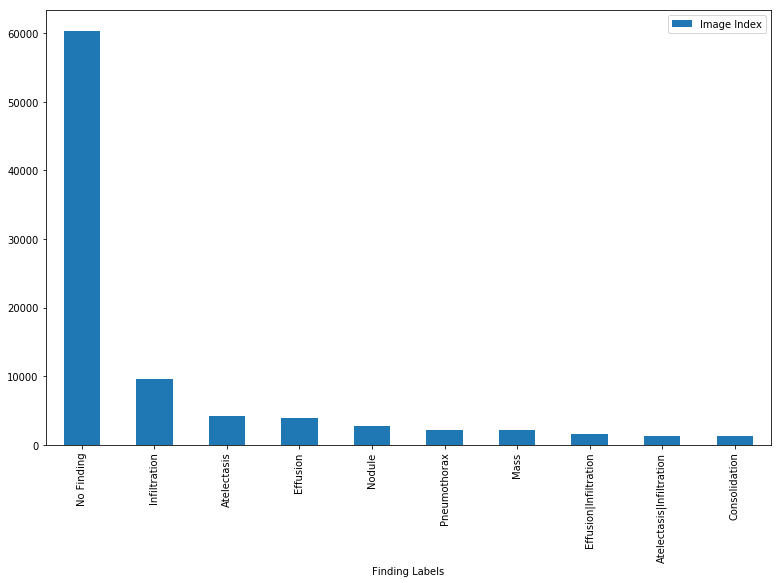

In [220]:
df_sorted = df.pivot_table(index='Finding Labels', aggfunc=len).sort_values('Image Index', ascending=False) 
df_sorted[0:10].plot(kind='bar',figsize=(13,8))

In [221]:
df_sorted.head(10)

,Image Index
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
Pneumothorax,2194
Mass,2139
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350


## Analyzing a specific disease
If this returns true, then skip to <i> view data</i> section

In [222]:
disease_name = 'Pneumothorax'
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv' 
exists = os.path.exists(cleaned_label_path)
if(False): 
    df = pd.read_csv(cleaned_label_path)
print('If exists equals true, then skip to view data section')
print('exists = ' + str(exists))

If exists equals true, then skip to view data section
exists = True


In [223]:
df_disease = df_sorted[df_sorted.index.str.contains(disease_name)]
disease_row = df_sorted.loc[disease_name]['Image Index']
total_apperance = sum(df_disease['Image Index'])
print(disease_name +': ' + str(disease_row) + '\n'+ 'Total apperance: ' + str(total_apperance))

Pneumothorax: 2194
Total apperance: 5302


In [224]:
df.shape

(112120, 2)

In [225]:
df['searching_disease'] = df['Finding Labels'].str.contains(disease_name)
no_finding_idxs =  list(df.loc[df['Finding Labels'] == 'No Finding'].index)
searching_disease_idxs = list(df[df['searching_disease']].index) #all rows with disease_name 

In [226]:
arr = np.concatenate((no_finding_idxs, searching_disease_idxs))

In [227]:
df = df.iloc[df.index.get_indexer(arr)]

In [228]:
df.head()

,Image Index,Finding Labels,searching_disease
3,00000002_000.png,No Finding,False
13,00000005_000.png,No Finding,False
14,00000005_001.png,No Finding,False
15,00000005_002.png,No Finding,False
16,00000005_003.png,No Finding,False


In [229]:
df.shape

(65663, 3)

In [230]:
#her henter jeg test filen og tar ut alle bildene som skal være i test filen 

In [231]:
test_image_name_list = [line.rstrip('\n') for line in open(f'{PATH}test_list.txt')]
len(test_image_name_list)

25596

In [193]:
test_dic = {}
for img_name in test_image_name_list: 
    img_row = df.loc[df['Image Index'] == img_name]
    if not img_row.empty: 
        test_dic[img_name] = bool(img_row.searching_disease.values)
        pos = int(img_row.index.values)
        df = df.drop([pos])

38    No Finding
Name: Finding Labels, dtype: object
39    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
40    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
42    Effusion|Emphysema|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
43    Emphysema|Infiltration|Pleural_Thickening|Pneu...
Name: Finding Labels, dtype: object
46    No Finding
Name: Finding Labels, dtype: object
48    Effusion|Pneumonia|Pneumothorax
Name: Finding Labels, dtype: object
49    Pneumothorax
Name: Finding Labels, dtype: object
50    Pneumothorax
Name: Finding Labels, dtype: object
51    Pneumothorax
Name: Finding Labels, dtype: object
52    No Finding
Name: Finding Labels, dtype: object
53    No Finding
Name: Finding Labels, dtype: object
54    No Finding
Name: Finding Labels, dtype: object
55    No Finding
Name: Finding Labels, dtype: object
56    Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
57    No Finding
Name: Finding Labels, dtype: object
58  

1514    No Finding
Name: Finding Labels, dtype: object
1516    No Finding
Name: Finding Labels, dtype: object
1667    No Finding
Name: Finding Labels, dtype: object
1736    No Finding
Name: Finding Labels, dtype: object
1737    No Finding
Name: Finding Labels, dtype: object
1751    No Finding
Name: Finding Labels, dtype: object
1758    No Finding
Name: Finding Labels, dtype: object
1759    No Finding
Name: Finding Labels, dtype: object
1760    No Finding
Name: Finding Labels, dtype: object
1761    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
1763    Pneumothorax
Name: Finding Labels, dtype: object
1764    Pneumothorax
Name: Finding Labels, dtype: object
1769    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
1770    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
1771    Pneumothorax
Name: Finding Labels, dtype: object
1773    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
1774    Infiltration|Pneumothorax
Name: Finding Labels, dtyp

3256    No Finding
Name: Finding Labels, dtype: object
3257    No Finding
Name: Finding Labels, dtype: object
3260    No Finding
Name: Finding Labels, dtype: object
3262    No Finding
Name: Finding Labels, dtype: object
3353    No Finding
Name: Finding Labels, dtype: object
3354    No Finding
Name: Finding Labels, dtype: object
3355    No Finding
Name: Finding Labels, dtype: object
3356    No Finding
Name: Finding Labels, dtype: object
3378    No Finding
Name: Finding Labels, dtype: object
3380    No Finding
Name: Finding Labels, dtype: object
3400    No Finding
Name: Finding Labels, dtype: object
3654    No Finding
Name: Finding Labels, dtype: object
3656    No Finding
Name: Finding Labels, dtype: object
3677    Pneumothorax
Name: Finding Labels, dtype: object
3678    Pneumothorax
Name: Finding Labels, dtype: object
3682    No Finding
Name: Finding Labels, dtype: object
3685    No Finding
Name: Finding Labels, dtype: object
3689    No Finding
Name: Finding Labels, dtype: object
3692  

5101    No Finding
Name: Finding Labels, dtype: object
5103    No Finding
Name: Finding Labels, dtype: object
5112    No Finding
Name: Finding Labels, dtype: object
5115    No Finding
Name: Finding Labels, dtype: object
5116    No Finding
Name: Finding Labels, dtype: object
5119    No Finding
Name: Finding Labels, dtype: object
5120    No Finding
Name: Finding Labels, dtype: object
5124    No Finding
Name: Finding Labels, dtype: object
5139    No Finding
Name: Finding Labels, dtype: object
5142    No Finding
Name: Finding Labels, dtype: object
5154    No Finding
Name: Finding Labels, dtype: object
5155    No Finding
Name: Finding Labels, dtype: object
5156    No Finding
Name: Finding Labels, dtype: object
5157    No Finding
Name: Finding Labels, dtype: object
5158    No Finding
Name: Finding Labels, dtype: object
5159    No Finding
Name: Finding Labels, dtype: object
5162    Pneumothorax
Name: Finding Labels, dtype: object
5163    No Finding
Name: Finding Labels, dtype: object
5164    

6869    No Finding
Name: Finding Labels, dtype: object
6872    No Finding
Name: Finding Labels, dtype: object
6873    No Finding
Name: Finding Labels, dtype: object
6875    No Finding
Name: Finding Labels, dtype: object
6876    No Finding
Name: Finding Labels, dtype: object
6877    No Finding
Name: Finding Labels, dtype: object
6878    No Finding
Name: Finding Labels, dtype: object
6880    No Finding
Name: Finding Labels, dtype: object
6881    No Finding
Name: Finding Labels, dtype: object
6885    No Finding
Name: Finding Labels, dtype: object
6886    No Finding
Name: Finding Labels, dtype: object
6887    No Finding
Name: Finding Labels, dtype: object
6888    No Finding
Name: Finding Labels, dtype: object
6893    No Finding
Name: Finding Labels, dtype: object
6894    No Finding
Name: Finding Labels, dtype: object
6898    No Finding
Name: Finding Labels, dtype: object
6899    No Finding
Name: Finding Labels, dtype: object
6900    No Finding
Name: Finding Labels, dtype: object
6901    No

9172    No Finding
Name: Finding Labels, dtype: object
9178    No Finding
Name: Finding Labels, dtype: object
9179    No Finding
Name: Finding Labels, dtype: object
9185    No Finding
Name: Finding Labels, dtype: object
9270    No Finding
Name: Finding Labels, dtype: object
9271    No Finding
Name: Finding Labels, dtype: object
9272    No Finding
Name: Finding Labels, dtype: object
9294    No Finding
Name: Finding Labels, dtype: object
9296    No Finding
Name: Finding Labels, dtype: object
9297    No Finding
Name: Finding Labels, dtype: object
9298    No Finding
Name: Finding Labels, dtype: object
9299    No Finding
Name: Finding Labels, dtype: object
9300    No Finding
Name: Finding Labels, dtype: object
9301    No Finding
Name: Finding Labels, dtype: object
9302    No Finding
Name: Finding Labels, dtype: object
9305    No Finding
Name: Finding Labels, dtype: object
9306    No Finding
Name: Finding Labels, dtype: object
9334    No Finding
Name: Finding Labels, dtype: object
9335    No

10878    No Finding
Name: Finding Labels, dtype: object
10879    Pneumothorax
Name: Finding Labels, dtype: object
10880    No Finding
Name: Finding Labels, dtype: object
10881    No Finding
Name: Finding Labels, dtype: object
10984    No Finding
Name: Finding Labels, dtype: object
10985    No Finding
Name: Finding Labels, dtype: object
10986    No Finding
Name: Finding Labels, dtype: object
10987    No Finding
Name: Finding Labels, dtype: object
10988    No Finding
Name: Finding Labels, dtype: object
10995    No Finding
Name: Finding Labels, dtype: object
11069    Atelectasis|Infiltration|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
11070    No Finding
Name: Finding Labels, dtype: object
11071    Pneumothorax
Name: Finding Labels, dtype: object
11072    Pneumothorax
Name: Finding Labels, dtype: object
11073    No Finding
Name: Finding Labels, dtype: object
11074    Infiltration|Mass|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
11075    No Finding
Name: Finding Lab

12082    No Finding
Name: Finding Labels, dtype: object
12086    No Finding
Name: Finding Labels, dtype: object
12087    No Finding
Name: Finding Labels, dtype: object
12411    Mass|Pneumothorax
Name: Finding Labels, dtype: object
12412    Pneumothorax
Name: Finding Labels, dtype: object
12413    No Finding
Name: Finding Labels, dtype: object
12414    No Finding
Name: Finding Labels, dtype: object
12417    No Finding
Name: Finding Labels, dtype: object
12418    Pneumothorax
Name: Finding Labels, dtype: object
12419    Pneumothorax
Name: Finding Labels, dtype: object
12426    No Finding
Name: Finding Labels, dtype: object
12920    No Finding
Name: Finding Labels, dtype: object
12923    No Finding
Name: Finding Labels, dtype: object
13048    No Finding
Name: Finding Labels, dtype: object
13049    No Finding
Name: Finding Labels, dtype: object
13050    No Finding
Name: Finding Labels, dtype: object
13065    No Finding
Name: Finding Labels, dtype: object
13066    Mass|Pneumothorax
Name: Fi

16406    No Finding
Name: Finding Labels, dtype: object
16409    No Finding
Name: Finding Labels, dtype: object
16410    No Finding
Name: Finding Labels, dtype: object
16411    No Finding
Name: Finding Labels, dtype: object
16413    No Finding
Name: Finding Labels, dtype: object
16414    No Finding
Name: Finding Labels, dtype: object
16420    No Finding
Name: Finding Labels, dtype: object
16423    No Finding
Name: Finding Labels, dtype: object
16429    No Finding
Name: Finding Labels, dtype: object
16431    No Finding
Name: Finding Labels, dtype: object
16439    No Finding
Name: Finding Labels, dtype: object
16442    No Finding
Name: Finding Labels, dtype: object
16445    No Finding
Name: Finding Labels, dtype: object
16446    No Finding
Name: Finding Labels, dtype: object
16448    No Finding
Name: Finding Labels, dtype: object
16452    No Finding
Name: Finding Labels, dtype: object
16643    No Finding
Name: Finding Labels, dtype: object
16644    No Finding
Name: Finding Labels, dtype:

17998    No Finding
Name: Finding Labels, dtype: object
18001    No Finding
Name: Finding Labels, dtype: object
18006    Consolidation|Pneumonia|Pneumothorax
Name: Finding Labels, dtype: object
18007    Consolidation|Pneumothorax
Name: Finding Labels, dtype: object
18008    Consolidation|Edema|Pneumothorax
Name: Finding Labels, dtype: object
18016    No Finding
Name: Finding Labels, dtype: object
18186    No Finding
Name: Finding Labels, dtype: object
18187    Effusion|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
18188    Infiltration|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
18190    Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
18191    Pneumothorax
Name: Finding Labels, dtype: object
18192    No Finding
Name: Finding Labels, dtype: object
18193    No Finding
Name: Finding Labels, dtype: object
18195    No Finding
Name: Finding Labels, dtype: object
18196    No Finding
Name: Finding Labels, dtype: object
18198 

Name: Finding Labels, dtype: object
19208    No Finding
Name: Finding Labels, dtype: object
19209    No Finding
Name: Finding Labels, dtype: object
19210    No Finding
Name: Finding Labels, dtype: object
19212    No Finding
Name: Finding Labels, dtype: object
19213    No Finding
Name: Finding Labels, dtype: object
19214    No Finding
Name: Finding Labels, dtype: object
19216    No Finding
Name: Finding Labels, dtype: object
19218    No Finding
Name: Finding Labels, dtype: object
19223    No Finding
Name: Finding Labels, dtype: object
19227    No Finding
Name: Finding Labels, dtype: object
19229    No Finding
Name: Finding Labels, dtype: object
19237    No Finding
Name: Finding Labels, dtype: object
19325    No Finding
Name: Finding Labels, dtype: object
19393    Pneumothorax
Name: Finding Labels, dtype: object
19394    No Finding
Name: Finding Labels, dtype: object
19395    Pneumothorax
Name: Finding Labels, dtype: object
19396    Pneumothorax
Name: Finding Labels, dtype: object
19397 

22097    No Finding
Name: Finding Labels, dtype: object
22100    No Finding
Name: Finding Labels, dtype: object
22145    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
22146    Pneumothorax|Pneumonia
Name: Finding Labels, dtype: object
22448    No Finding
Name: Finding Labels, dtype: object
22450    No Finding
Name: Finding Labels, dtype: object
22451    No Finding
Name: Finding Labels, dtype: object
22452    No Finding
Name: Finding Labels, dtype: object
22453    No Finding
Name: Finding Labels, dtype: object
22454    No Finding
Name: Finding Labels, dtype: object
22455    No Finding
Name: Finding Labels, dtype: object
22456    No Finding
Name: Finding Labels, dtype: object
22457    No Finding
Name: Finding Labels, dtype: object
22458    No Finding
Name: Finding Labels, dtype: object
22459    No Finding
Name: Finding Labels, dtype: object
22460    No Finding
Name: Finding Labels, dtype: object
22461    No Finding
Name: Finding Labels, dtype: object
22462    No Finding
N

24083    No Finding
Name: Finding Labels, dtype: object
24084    No Finding
Name: Finding Labels, dtype: object
24247    No Finding
Name: Finding Labels, dtype: object
24389    No Finding
Name: Finding Labels, dtype: object
24390    No Finding
Name: Finding Labels, dtype: object
24392    No Finding
Name: Finding Labels, dtype: object
24397    No Finding
Name: Finding Labels, dtype: object
24409    No Finding
Name: Finding Labels, dtype: object
24415    No Finding
Name: Finding Labels, dtype: object
24417    No Finding
Name: Finding Labels, dtype: object
24420    No Finding
Name: Finding Labels, dtype: object
24421    No Finding
Name: Finding Labels, dtype: object
24424    No Finding
Name: Finding Labels, dtype: object
24425    No Finding
Name: Finding Labels, dtype: object
24426    No Finding
Name: Finding Labels, dtype: object
24427    No Finding
Name: Finding Labels, dtype: object
24428    No Finding
Name: Finding Labels, dtype: object
24429    No Finding
Name: Finding Labels, dtype:

26816    No Finding
Name: Finding Labels, dtype: object
26817    No Finding
Name: Finding Labels, dtype: object
26818    No Finding
Name: Finding Labels, dtype: object
26821    No Finding
Name: Finding Labels, dtype: object
26822    No Finding
Name: Finding Labels, dtype: object
26823    No Finding
Name: Finding Labels, dtype: object
26826    No Finding
Name: Finding Labels, dtype: object
26827    No Finding
Name: Finding Labels, dtype: object
26828    No Finding
Name: Finding Labels, dtype: object
26829    No Finding
Name: Finding Labels, dtype: object
26830    No Finding
Name: Finding Labels, dtype: object
26831    No Finding
Name: Finding Labels, dtype: object
26832    No Finding
Name: Finding Labels, dtype: object
26833    No Finding
Name: Finding Labels, dtype: object
26834    No Finding
Name: Finding Labels, dtype: object
26835    No Finding
Name: Finding Labels, dtype: object
26842    No Finding
Name: Finding Labels, dtype: object
26843    No Finding
Name: Finding Labels, dtype:

29345    No Finding
Name: Finding Labels, dtype: object
29346    No Finding
Name: Finding Labels, dtype: object
29347    No Finding
Name: Finding Labels, dtype: object
29348    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
29429    No Finding
Name: Finding Labels, dtype: object
29431    No Finding
Name: Finding Labels, dtype: object
29437    No Finding
Name: Finding Labels, dtype: object
29438    No Finding
Name: Finding Labels, dtype: object
29441    Pneumothorax
Name: Finding Labels, dtype: object
29442    Pneumothorax
Name: Finding Labels, dtype: object
29443    Pneumothorax
Name: Finding Labels, dtype: object
29444    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
29445    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
29446    No Finding
Name: Finding Labels, dtype: object
29447    Emphysema|Fibrosis|Pneumothorax
Name: Finding Labels, dtype: object
29448    Consolidation|Fibrosis|Pneumothorax
Name: Finding Labels, dtype: object
29449    

30257    No Finding
Name: Finding Labels, dtype: object
30278    No Finding
Name: Finding Labels, dtype: object
30336    No Finding
Name: Finding Labels, dtype: object
30337    No Finding
Name: Finding Labels, dtype: object
30338    No Finding
Name: Finding Labels, dtype: object
30339    No Finding
Name: Finding Labels, dtype: object
30343    No Finding
Name: Finding Labels, dtype: object
30346    No Finding
Name: Finding Labels, dtype: object
30347    No Finding
Name: Finding Labels, dtype: object
30438    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
30439    No Finding
Name: Finding Labels, dtype: object
30440    No Finding
Name: Finding Labels, dtype: object
30443    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
30444    No Finding
Name: Finding Labels, dtype: object
30446    No Finding
Name: Finding Labels, dtype: object
30447    No Finding
Name: Finding Labels, dtype: object
30448    No Finding
Name: Finding Labels, dtype: object
30449    Infiltration

32594    No Finding
Name: Finding Labels, dtype: object
32599    No Finding
Name: Finding Labels, dtype: object
32600    No Finding
Name: Finding Labels, dtype: object
32601    No Finding
Name: Finding Labels, dtype: object
32602    No Finding
Name: Finding Labels, dtype: object
32603    No Finding
Name: Finding Labels, dtype: object
32604    No Finding
Name: Finding Labels, dtype: object
32610    No Finding
Name: Finding Labels, dtype: object
32615    No Finding
Name: Finding Labels, dtype: object
32631    No Finding
Name: Finding Labels, dtype: object
32632    No Finding
Name: Finding Labels, dtype: object
32636    No Finding
Name: Finding Labels, dtype: object
32637    No Finding
Name: Finding Labels, dtype: object
32638    No Finding
Name: Finding Labels, dtype: object
32639    No Finding
Name: Finding Labels, dtype: object
32640    No Finding
Name: Finding Labels, dtype: object
32641    No Finding
Name: Finding Labels, dtype: object
32642    No Finding
Name: Finding Labels, dtype:

34057    No Finding
Name: Finding Labels, dtype: object
34109    No Finding
Name: Finding Labels, dtype: object
34110    No Finding
Name: Finding Labels, dtype: object
34233    No Finding
Name: Finding Labels, dtype: object
34234    No Finding
Name: Finding Labels, dtype: object
34315    No Finding
Name: Finding Labels, dtype: object
34318    No Finding
Name: Finding Labels, dtype: object
34659    No Finding
Name: Finding Labels, dtype: object
34661    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
34662    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
34663    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
34664    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
34665    No Finding
Name: Finding Labels, dtype: object
34667    No Finding
Name: Finding Labels, dtype: object
34668    No Finding
Name: Finding Labels, dtype: object
34669    No Finding
Name: Finding Labels, dtype: object
34674    No Finding
Name: Finding Labels, dt

35660    No Finding
Name: Finding Labels, dtype: object
35688    No Finding
Name: Finding Labels, dtype: object
35689    No Finding
Name: Finding Labels, dtype: object
35690    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
35692    Pneumothorax
Name: Finding Labels, dtype: object
35693    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
35696    No Finding
Name: Finding Labels, dtype: object
35698    No Finding
Name: Finding Labels, dtype: object
35776    No Finding
Name: Finding Labels, dtype: object
35781    No Finding
Name: Finding Labels, dtype: object
35782    No Finding
Name: Finding Labels, dtype: object
35783    No Finding
Name: Finding Labels, dtype: object
35784    No Finding
Name: Finding Labels, dtype: object
35785    No Finding
Name: Finding Labels, dtype: object
35786    No Finding
Name: Finding Labels, dtype: object
35787    No Finding
Name: Finding Labels, dtype: object
35790    No Finding
Name: Finding Labels, dtype: object
35814    No Finding
Name: Fi

37489    No Finding
Name: Finding Labels, dtype: object
37490    No Finding
Name: Finding Labels, dtype: object
37491    No Finding
Name: Finding Labels, dtype: object
37493    No Finding
Name: Finding Labels, dtype: object
37494    No Finding
Name: Finding Labels, dtype: object
37497    No Finding
Name: Finding Labels, dtype: object
37498    No Finding
Name: Finding Labels, dtype: object
37501    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
37503    Pneumothorax
Name: Finding Labels, dtype: object
37504    Pneumothorax
Name: Finding Labels, dtype: object
37505    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
37506    Consolidation|Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
37507    Pneumothorax
Name: Finding Labels, dtype: object
37508    No Finding
Name: Finding Labels, dtype: object
37509    No Finding
Name: Finding Labels, dtype: object
37511    No Finding
Name: Finding Labels, dtype: object
37513    No Finding
Name: Finding Lab

38565    Pneumothorax
Name: Finding Labels, dtype: object
38566    Pneumothorax
Name: Finding Labels, dtype: object
38567    No Finding
Name: Finding Labels, dtype: object
38623    No Finding
Name: Finding Labels, dtype: object
38624    No Finding
Name: Finding Labels, dtype: object
38625    No Finding
Name: Finding Labels, dtype: object
38627    No Finding
Name: Finding Labels, dtype: object
38628    No Finding
Name: Finding Labels, dtype: object
38629    No Finding
Name: Finding Labels, dtype: object
38630    No Finding
Name: Finding Labels, dtype: object
38631    No Finding
Name: Finding Labels, dtype: object
38633    No Finding
Name: Finding Labels, dtype: object
38635    Atelectasis|Consolidation|Pneumothorax
Name: Finding Labels, dtype: object
38638    No Finding
Name: Finding Labels, dtype: object
38639    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
38640    No Finding
Name: Finding Labels, dtype: object
38641    Atelectasis|Emphysema|Infiltration|Pneumothorax


40552    No Finding
Name: Finding Labels, dtype: object
40553    No Finding
Name: Finding Labels, dtype: object
40554    No Finding
Name: Finding Labels, dtype: object
40560    No Finding
Name: Finding Labels, dtype: object
40687    No Finding
Name: Finding Labels, dtype: object
40688    No Finding
Name: Finding Labels, dtype: object
40689    No Finding
Name: Finding Labels, dtype: object
40692    No Finding
Name: Finding Labels, dtype: object
40694    No Finding
Name: Finding Labels, dtype: object
40695    No Finding
Name: Finding Labels, dtype: object
40696    No Finding
Name: Finding Labels, dtype: object
40697    No Finding
Name: Finding Labels, dtype: object
40698    No Finding
Name: Finding Labels, dtype: object
40699    No Finding
Name: Finding Labels, dtype: object
40700    No Finding
Name: Finding Labels, dtype: object
40701    No Finding
Name: Finding Labels, dtype: object
40702    No Finding
Name: Finding Labels, dtype: object
40703    No Finding
Name: Finding Labels, dtype:

42102    No Finding
Name: Finding Labels, dtype: object
42105    No Finding
Name: Finding Labels, dtype: object
42106    No Finding
Name: Finding Labels, dtype: object
42115    No Finding
Name: Finding Labels, dtype: object
42119    No Finding
Name: Finding Labels, dtype: object
42251    No Finding
Name: Finding Labels, dtype: object
42252    No Finding
Name: Finding Labels, dtype: object
42254    No Finding
Name: Finding Labels, dtype: object
42255    No Finding
Name: Finding Labels, dtype: object
42256    No Finding
Name: Finding Labels, dtype: object
42257    No Finding
Name: Finding Labels, dtype: object
42258    No Finding
Name: Finding Labels, dtype: object
42259    No Finding
Name: Finding Labels, dtype: object
42262    No Finding
Name: Finding Labels, dtype: object
42263    No Finding
Name: Finding Labels, dtype: object
42265    No Finding
Name: Finding Labels, dtype: object
42266    No Finding
Name: Finding Labels, dtype: object
42268    No Finding
Name: Finding Labels, dtype:

43762    Atelectasis|Effusion|Infiltration|Mass|Pneumot...
Name: Finding Labels, dtype: object
43763    No Finding
Name: Finding Labels, dtype: object
43810    No Finding
Name: Finding Labels, dtype: object
43815    No Finding
Name: Finding Labels, dtype: object
43892    No Finding
Name: Finding Labels, dtype: object
43945    No Finding
Name: Finding Labels, dtype: object
44003    Pneumothorax
Name: Finding Labels, dtype: object
44005    Mass|Pneumothorax
Name: Finding Labels, dtype: object
44006    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
44007    Mass|Pneumothorax
Name: Finding Labels, dtype: object
44008    Mass|Pneumothorax
Name: Finding Labels, dtype: object
44009    Pneumothorax
Name: Finding Labels, dtype: object
44010    Pneumothorax
Name: Finding Labels, dtype: object
44011    Pneumothorax
Name: Finding Labels, dtype: object
44012    No Finding
Name: Finding Labels, dtype: object
44013    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
44014 

44575    Pneumothorax
Name: Finding Labels, dtype: object
44576    Pneumothorax
Name: Finding Labels, dtype: object
44577    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
44578    No Finding
Name: Finding Labels, dtype: object
44579    Atelectasis|Emphysema|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
44580    Pneumothorax
Name: Finding Labels, dtype: object
44581    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
44582    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
44583    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
44584    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
44585    Pneumothorax
Name: Finding Labels, dtype: object
44586    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
44587    Pneumothorax
Name: Finding Labels, dtype: object
44588    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
44589    Pneumothorax
Name: Finding Labels, dtype: object
44590    Pleural_Thick

46081    No Finding
Name: Finding Labels, dtype: object
46084    No Finding
Name: Finding Labels, dtype: object
46088    No Finding
Name: Finding Labels, dtype: object
46090    Effusion|Mass|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
46098    Emphysema|Mass|Pneumothorax
Name: Finding Labels, dtype: object
46099    Emphysema|Mass|Pneumothorax
Name: Finding Labels, dtype: object
46100    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
46101    Pneumothorax
Name: Finding Labels, dtype: object
46102    Effusion|Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
46103    No Finding
Name: Finding Labels, dtype: object
46157    No Finding
Name: Finding Labels, dtype: object
46158    No Finding
Name: Finding Labels, dtype: object
46159    No Finding
Name: Finding Labels, dtype: object
46162    No Finding
Name: Finding Labels, dtype: object
46163    No Finding
Name: Finding Labels, dtype: object
46166    Pneumothorax
Name: Finding Labels, dtype: obj

47248    Pneumothorax
Name: Finding Labels, dtype: object
47249    No Finding
Name: Finding Labels, dtype: object
47251    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
47254    No Finding
Name: Finding Labels, dtype: object
47256    No Finding
Name: Finding Labels, dtype: object
47258    No Finding
Name: Finding Labels, dtype: object
47259    No Finding
Name: Finding Labels, dtype: object
47263    No Finding
Name: Finding Labels, dtype: object
47264    No Finding
Name: Finding Labels, dtype: object
47268    No Finding
Name: Finding Labels, dtype: object
47269    No Finding
Name: Finding Labels, dtype: object
47270    No Finding
Name: Finding Labels, dtype: object
47271    No Finding
Name: Finding Labels, dtype: object
47279    No Finding
Name: Finding Labels, dtype: object
47287    No Finding
Name: Finding Labels, dtype: object
47288    No Finding
Name: Finding Labels, dtype: object
47291    No Finding
Name: Finding Labels, dtype: object
47298    No Finding
Name: Findi

47882    No Finding
Name: Finding Labels, dtype: object
47892    No Finding
Name: Finding Labels, dtype: object
47893    No Finding
Name: Finding Labels, dtype: object
47966    No Finding
Name: Finding Labels, dtype: object
47969    No Finding
Name: Finding Labels, dtype: object
48064    No Finding
Name: Finding Labels, dtype: object
48065    No Finding
Name: Finding Labels, dtype: object
48066    No Finding
Name: Finding Labels, dtype: object
48068    No Finding
Name: Finding Labels, dtype: object
48069    No Finding
Name: Finding Labels, dtype: object
48070    No Finding
Name: Finding Labels, dtype: object
48357    No Finding
Name: Finding Labels, dtype: object
48358    No Finding
Name: Finding Labels, dtype: object
48363    No Finding
Name: Finding Labels, dtype: object
48381    Infiltration|Mass|Pneumothorax
Name: Finding Labels, dtype: object
48382    No Finding
Name: Finding Labels, dtype: object
48456    No Finding
Name: Finding Labels, dtype: object
48459    No Finding
Name: Fi

50160    No Finding
Name: Finding Labels, dtype: object
50161    No Finding
Name: Finding Labels, dtype: object
50165    No Finding
Name: Finding Labels, dtype: object
50166    No Finding
Name: Finding Labels, dtype: object
50167    No Finding
Name: Finding Labels, dtype: object
50325    No Finding
Name: Finding Labels, dtype: object
50326    No Finding
Name: Finding Labels, dtype: object
50327    No Finding
Name: Finding Labels, dtype: object
50328    No Finding
Name: Finding Labels, dtype: object
50331    No Finding
Name: Finding Labels, dtype: object
50332    No Finding
Name: Finding Labels, dtype: object
50334    No Finding
Name: Finding Labels, dtype: object
50335    No Finding
Name: Finding Labels, dtype: object
50338    No Finding
Name: Finding Labels, dtype: object
50339    No Finding
Name: Finding Labels, dtype: object
50340    No Finding
Name: Finding Labels, dtype: object
50341    No Finding
Name: Finding Labels, dtype: object
50342    No Finding
Name: Finding Labels, dtype:

51950    No Finding
Name: Finding Labels, dtype: object
51951    No Finding
Name: Finding Labels, dtype: object
51952    No Finding
Name: Finding Labels, dtype: object
51953    No Finding
Name: Finding Labels, dtype: object
51955    No Finding
Name: Finding Labels, dtype: object
51957    No Finding
Name: Finding Labels, dtype: object
51958    No Finding
Name: Finding Labels, dtype: object
51960    No Finding
Name: Finding Labels, dtype: object
51967    No Finding
Name: Finding Labels, dtype: object
51968    No Finding
Name: Finding Labels, dtype: object
51969    Pneumothorax
Name: Finding Labels, dtype: object
51970    No Finding
Name: Finding Labels, dtype: object
51972    No Finding
Name: Finding Labels, dtype: object
51982    No Finding
Name: Finding Labels, dtype: object
51983    No Finding
Name: Finding Labels, dtype: object
51984    No Finding
Name: Finding Labels, dtype: object
51985    No Finding
Name: Finding Labels, dtype: object
51986    No Finding
Name: Finding Labels, dtyp

52822    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52823    Emphysema|Fibrosis|Pneumothorax
Name: Finding Labels, dtype: object
52824    Pneumothorax|Infiltration
Name: Finding Labels, dtype: object
52825    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
52826    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52827    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52828    Emphysema|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52829    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52830    No Finding
Name: Finding Labels, dtype: object
52832    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52833    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
52834    Pneumothorax
Name: Finding Labels, dtype: object
52835    Pneumothorax
Name: Finding Labels, dtype: object
52928    No Finding
Name: Finding Labels, dtype: object
52935    Effusion|Nodule|Pneumothorax
Name: Findi

54171    No Finding
Name: Finding Labels, dtype: object
54172    No Finding
Name: Finding Labels, dtype: object
54173    No Finding
Name: Finding Labels, dtype: object
54175    No Finding
Name: Finding Labels, dtype: object
54176    No Finding
Name: Finding Labels, dtype: object
54177    No Finding
Name: Finding Labels, dtype: object
54178    No Finding
Name: Finding Labels, dtype: object
54179    No Finding
Name: Finding Labels, dtype: object
54181    No Finding
Name: Finding Labels, dtype: object
54184    No Finding
Name: Finding Labels, dtype: object
54185    No Finding
Name: Finding Labels, dtype: object
54186    No Finding
Name: Finding Labels, dtype: object
54193    No Finding
Name: Finding Labels, dtype: object
54199    No Finding
Name: Finding Labels, dtype: object
54203    No Finding
Name: Finding Labels, dtype: object
54206    No Finding
Name: Finding Labels, dtype: object
54208    No Finding
Name: Finding Labels, dtype: object
54210    No Finding
Name: Finding Labels, dtype:

54915    No Finding
Name: Finding Labels, dtype: object
54916    No Finding
Name: Finding Labels, dtype: object
55114    No Finding
Name: Finding Labels, dtype: object
55115    No Finding
Name: Finding Labels, dtype: object
55123    Pneumothorax
Name: Finding Labels, dtype: object
55124    No Finding
Name: Finding Labels, dtype: object
55125    No Finding
Name: Finding Labels, dtype: object
55128    No Finding
Name: Finding Labels, dtype: object
55129    Pneumothorax
Name: Finding Labels, dtype: object
55130    Pneumothorax
Name: Finding Labels, dtype: object
55131    No Finding
Name: Finding Labels, dtype: object
55150    No Finding
Name: Finding Labels, dtype: object
55152    No Finding
Name: Finding Labels, dtype: object
55153    No Finding
Name: Finding Labels, dtype: object
55154    No Finding
Name: Finding Labels, dtype: object
55324    No Finding
Name: Finding Labels, dtype: object
55327    No Finding
Name: Finding Labels, dtype: object
55329    No Finding
Name: Finding Labels, 

Name: Finding Labels, dtype: object
56329    No Finding
Name: Finding Labels, dtype: object
56330    No Finding
Name: Finding Labels, dtype: object
56331    No Finding
Name: Finding Labels, dtype: object
56332    No Finding
Name: Finding Labels, dtype: object
56333    No Finding
Name: Finding Labels, dtype: object
56343    No Finding
Name: Finding Labels, dtype: object
56344    No Finding
Name: Finding Labels, dtype: object
56345    No Finding
Name: Finding Labels, dtype: object
56346    No Finding
Name: Finding Labels, dtype: object
56349    No Finding
Name: Finding Labels, dtype: object
56350    No Finding
Name: Finding Labels, dtype: object
56351    No Finding
Name: Finding Labels, dtype: object
56356    No Finding
Name: Finding Labels, dtype: object
56359    No Finding
Name: Finding Labels, dtype: object
56360    No Finding
Name: Finding Labels, dtype: object
56361    No Finding
Name: Finding Labels, dtype: object
56364    No Finding
Name: Finding Labels, dtype: object
56368    No 

57211    No Finding
Name: Finding Labels, dtype: object
57212    No Finding
Name: Finding Labels, dtype: object
57213    No Finding
Name: Finding Labels, dtype: object
57215    No Finding
Name: Finding Labels, dtype: object
57216    No Finding
Name: Finding Labels, dtype: object
57217    No Finding
Name: Finding Labels, dtype: object
57218    No Finding
Name: Finding Labels, dtype: object
57219    No Finding
Name: Finding Labels, dtype: object
57220    No Finding
Name: Finding Labels, dtype: object
57226    No Finding
Name: Finding Labels, dtype: object
57227    No Finding
Name: Finding Labels, dtype: object
57228    No Finding
Name: Finding Labels, dtype: object
57229    No Finding
Name: Finding Labels, dtype: object
57230    No Finding
Name: Finding Labels, dtype: object
57233    No Finding
Name: Finding Labels, dtype: object
57234    No Finding
Name: Finding Labels, dtype: object
57235    No Finding
Name: Finding Labels, dtype: object
57236    No Finding
Name: Finding Labels, dtype:

58246    No Finding
Name: Finding Labels, dtype: object
58251    No Finding
Name: Finding Labels, dtype: object
58252    No Finding
Name: Finding Labels, dtype: object
58256    No Finding
Name: Finding Labels, dtype: object
58426    No Finding
Name: Finding Labels, dtype: object
58427    No Finding
Name: Finding Labels, dtype: object
58584    No Finding
Name: Finding Labels, dtype: object
58585    No Finding
Name: Finding Labels, dtype: object
58668    No Finding
Name: Finding Labels, dtype: object
58669    No Finding
Name: Finding Labels, dtype: object
58670    No Finding
Name: Finding Labels, dtype: object
58671    No Finding
Name: Finding Labels, dtype: object
58672    No Finding
Name: Finding Labels, dtype: object
58673    No Finding
Name: Finding Labels, dtype: object
58674    Pneumothorax
Name: Finding Labels, dtype: object
58675    Pneumothorax
Name: Finding Labels, dtype: object
58676    Pneumothorax
Name: Finding Labels, dtype: object
58677    Pneumothorax
Name: Finding Labels

59504    No Finding
Name: Finding Labels, dtype: object
59505    No Finding
Name: Finding Labels, dtype: object
59506    No Finding
Name: Finding Labels, dtype: object
59507    No Finding
Name: Finding Labels, dtype: object
59516    No Finding
Name: Finding Labels, dtype: object
59517    No Finding
Name: Finding Labels, dtype: object
59518    No Finding
Name: Finding Labels, dtype: object
59580    No Finding
Name: Finding Labels, dtype: object
59581    No Finding
Name: Finding Labels, dtype: object
59583    No Finding
Name: Finding Labels, dtype: object
59584    No Finding
Name: Finding Labels, dtype: object
59585    No Finding
Name: Finding Labels, dtype: object
59588    No Finding
Name: Finding Labels, dtype: object
59611    No Finding
Name: Finding Labels, dtype: object
59613    No Finding
Name: Finding Labels, dtype: object
59668    Mass|Pneumothorax
Name: Finding Labels, dtype: object
59669    Atelectasis|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
59670    Mass|

60707    No Finding
Name: Finding Labels, dtype: object
60708    No Finding
Name: Finding Labels, dtype: object
60709    No Finding
Name: Finding Labels, dtype: object
60710    No Finding
Name: Finding Labels, dtype: object
60711    No Finding
Name: Finding Labels, dtype: object
60712    No Finding
Name: Finding Labels, dtype: object
60713    No Finding
Name: Finding Labels, dtype: object
60714    No Finding
Name: Finding Labels, dtype: object
60715    No Finding
Name: Finding Labels, dtype: object
60716    No Finding
Name: Finding Labels, dtype: object
60717    No Finding
Name: Finding Labels, dtype: object
60718    No Finding
Name: Finding Labels, dtype: object
60719    No Finding
Name: Finding Labels, dtype: object
60720    No Finding
Name: Finding Labels, dtype: object
60721    No Finding
Name: Finding Labels, dtype: object
60722    No Finding
Name: Finding Labels, dtype: object
60723    No Finding
Name: Finding Labels, dtype: object
60724    No Finding
Name: Finding Labels, dtype:

62353    No Finding
Name: Finding Labels, dtype: object
62354    No Finding
Name: Finding Labels, dtype: object
62355    No Finding
Name: Finding Labels, dtype: object
62356    No Finding
Name: Finding Labels, dtype: object
62357    No Finding
Name: Finding Labels, dtype: object
62358    No Finding
Name: Finding Labels, dtype: object
62359    No Finding
Name: Finding Labels, dtype: object
62360    No Finding
Name: Finding Labels, dtype: object
62361    No Finding
Name: Finding Labels, dtype: object
62389    No Finding
Name: Finding Labels, dtype: object
62392    No Finding
Name: Finding Labels, dtype: object
62393    No Finding
Name: Finding Labels, dtype: object
62394    No Finding
Name: Finding Labels, dtype: object
62395    No Finding
Name: Finding Labels, dtype: object
62396    No Finding
Name: Finding Labels, dtype: object
62397    No Finding
Name: Finding Labels, dtype: object
62398    No Finding
Name: Finding Labels, dtype: object
62400    No Finding
Name: Finding Labels, dtype:

63103    No Finding
Name: Finding Labels, dtype: object
63105    No Finding
Name: Finding Labels, dtype: object
63109    No Finding
Name: Finding Labels, dtype: object
63110    No Finding
Name: Finding Labels, dtype: object
63111    No Finding
Name: Finding Labels, dtype: object
63112    No Finding
Name: Finding Labels, dtype: object
63113    No Finding
Name: Finding Labels, dtype: object
63126    No Finding
Name: Finding Labels, dtype: object
63138    No Finding
Name: Finding Labels, dtype: object
63140    No Finding
Name: Finding Labels, dtype: object
63142    No Finding
Name: Finding Labels, dtype: object
63151    No Finding
Name: Finding Labels, dtype: object
63152    No Finding
Name: Finding Labels, dtype: object
63329    No Finding
Name: Finding Labels, dtype: object
63330    No Finding
Name: Finding Labels, dtype: object
63331    No Finding
Name: Finding Labels, dtype: object
63332    No Finding
Name: Finding Labels, dtype: object
63333    No Finding
Name: Finding Labels, dtype:

Name: Finding Labels, dtype: object
64611    No Finding
Name: Finding Labels, dtype: object
64612    No Finding
Name: Finding Labels, dtype: object
64613    No Finding
Name: Finding Labels, dtype: object
64614    No Finding
Name: Finding Labels, dtype: object
64615    No Finding
Name: Finding Labels, dtype: object
64616    No Finding
Name: Finding Labels, dtype: object
64620    No Finding
Name: Finding Labels, dtype: object
64624    No Finding
Name: Finding Labels, dtype: object
64628    No Finding
Name: Finding Labels, dtype: object
64629    No Finding
Name: Finding Labels, dtype: object
64631    No Finding
Name: Finding Labels, dtype: object
64640    No Finding
Name: Finding Labels, dtype: object
64644    No Finding
Name: Finding Labels, dtype: object
64646    No Finding
Name: Finding Labels, dtype: object
64647    No Finding
Name: Finding Labels, dtype: object
64659    No Finding
Name: Finding Labels, dtype: object
64764    No Finding
Name: Finding Labels, dtype: object
64800    No 

66438    No Finding
Name: Finding Labels, dtype: object
66439    Pneumothorax
Name: Finding Labels, dtype: object
66441    Atelectasis|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
66442    Atelectasis|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
66443    Pneumothorax
Name: Finding Labels, dtype: object
66444    Pneumothorax
Name: Finding Labels, dtype: object
66445    Pneumothorax
Name: Finding Labels, dtype: object
66447    No Finding
Name: Finding Labels, dtype: object
66449    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
66450    Pneumothorax
Name: Finding Labels, dtype: object
66451    Atelectasis|Effusion|Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
66452    Emphysema|Infiltration|Mass|Pneumothorax
Name: Finding Labels, dtype: object
66453    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
66454    Effusion|Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
66455    Atelectas

67098    Pneumothorax
Name: Finding Labels, dtype: object
67100    Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
67101    Pneumothorax
Name: Finding Labels, dtype: object
67102    Pneumothorax
Name: Finding Labels, dtype: object
67103    Pneumothorax
Name: Finding Labels, dtype: object
67104    Pneumothorax
Name: Finding Labels, dtype: object
67105    No Finding
Name: Finding Labels, dtype: object
67106    No Finding
Name: Finding Labels, dtype: object
67107    No Finding
Name: Finding Labels, dtype: object
67108    Pneumothorax
Name: Finding Labels, dtype: object
67109    Pneumothorax
Name: Finding Labels, dtype: object
67110    No Finding
Name: Finding Labels, dtype: object
67111    No Finding
Name: Finding Labels, dtype: object
67112    No Finding
Name: Finding Labels, dtype: object
67113    No Finding
Name: Finding Labels, dtype: object
67115    Pneumothorax
Name: Finding Labels, dtype: object
67116    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: obje

68146    No Finding
Name: Finding Labels, dtype: object
68179    No Finding
Name: Finding Labels, dtype: object
68180    No Finding
Name: Finding Labels, dtype: object
68181    No Finding
Name: Finding Labels, dtype: object
68182    No Finding
Name: Finding Labels, dtype: object
68184    No Finding
Name: Finding Labels, dtype: object
68185    No Finding
Name: Finding Labels, dtype: object
68251    No Finding
Name: Finding Labels, dtype: object
68255    No Finding
Name: Finding Labels, dtype: object
68598    Pneumothorax
Name: Finding Labels, dtype: object
68599    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
68600    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
68601    Pneumothorax
Name: Finding Labels, dtype: object
68605    No Finding
Name: Finding Labels, dtype: object
68606    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
68607    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
68608    Effusion|Mass|Pneumothorax
Name: Finding Labels, d

Name: Finding Labels, dtype: object
69557    No Finding
Name: Finding Labels, dtype: object
69561    No Finding
Name: Finding Labels, dtype: object
69562    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
69563    No Finding
Name: Finding Labels, dtype: object
69566    No Finding
Name: Finding Labels, dtype: object
69567    No Finding
Name: Finding Labels, dtype: object
69568    No Finding
Name: Finding Labels, dtype: object
69597    No Finding
Name: Finding Labels, dtype: object
69601    No Finding
Name: Finding Labels, dtype: object
69602    No Finding
Name: Finding Labels, dtype: object
69603    No Finding
Name: Finding Labels, dtype: object
69604    No Finding
Name: Finding Labels, dtype: object
69605    No Finding
Name: Finding Labels, dtype: object
69606    No Finding
Name: Finding Labels, dtype: object
69607    No Finding
Name: Finding Labels, dtype: object
69609    No Finding
Name: Finding Labels, dtype: object
69610    No Finding
Name: Finding Labels, dtype: object
6

70944    No Finding
Name: Finding Labels, dtype: object
70946    No Finding
Name: Finding Labels, dtype: object
70947    No Finding
Name: Finding Labels, dtype: object
70948    No Finding
Name: Finding Labels, dtype: object
70952    No Finding
Name: Finding Labels, dtype: object
70962    No Finding
Name: Finding Labels, dtype: object
70963    No Finding
Name: Finding Labels, dtype: object
70964    No Finding
Name: Finding Labels, dtype: object
70972    No Finding
Name: Finding Labels, dtype: object
70975    No Finding
Name: Finding Labels, dtype: object
70979    No Finding
Name: Finding Labels, dtype: object
70988    Pneumothorax
Name: Finding Labels, dtype: object
70989    No Finding
Name: Finding Labels, dtype: object
71001    No Finding
Name: Finding Labels, dtype: object
71007    No Finding
Name: Finding Labels, dtype: object
71013    No Finding
Name: Finding Labels, dtype: object
71014    No Finding
Name: Finding Labels, dtype: object
71015    No Finding
Name: Finding Labels, dtyp

72842    No Finding
Name: Finding Labels, dtype: object
72845    No Finding
Name: Finding Labels, dtype: object
72846    No Finding
Name: Finding Labels, dtype: object
72847    No Finding
Name: Finding Labels, dtype: object
72894    No Finding
Name: Finding Labels, dtype: object
72895    No Finding
Name: Finding Labels, dtype: object
72896    No Finding
Name: Finding Labels, dtype: object
72898    No Finding
Name: Finding Labels, dtype: object
72900    No Finding
Name: Finding Labels, dtype: object
72901    No Finding
Name: Finding Labels, dtype: object
72905    Pneumothorax
Name: Finding Labels, dtype: object
72906    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
72907    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
72908    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
72909    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
72910    No Finding
Name: Finding Labels, dtype: object
72911    Emphysema|Infiltration|Pneumothorax
Name: Fin

73990    No Finding
Name: Finding Labels, dtype: object
73993    No Finding
Name: Finding Labels, dtype: object
74004    No Finding
Name: Finding Labels, dtype: object
74045    No Finding
Name: Finding Labels, dtype: object
74134    No Finding
Name: Finding Labels, dtype: object
74135    No Finding
Name: Finding Labels, dtype: object
74137    No Finding
Name: Finding Labels, dtype: object
74143    No Finding
Name: Finding Labels, dtype: object
74152    No Finding
Name: Finding Labels, dtype: object
74153    No Finding
Name: Finding Labels, dtype: object
74157    No Finding
Name: Finding Labels, dtype: object
74158    No Finding
Name: Finding Labels, dtype: object
74159    No Finding
Name: Finding Labels, dtype: object
74160    No Finding
Name: Finding Labels, dtype: object
74161    No Finding
Name: Finding Labels, dtype: object
74162    No Finding
Name: Finding Labels, dtype: object
74165    No Finding
Name: Finding Labels, dtype: object
74166    No Finding
Name: Finding Labels, dtype:

74968    No Finding
Name: Finding Labels, dtype: object
74969    No Finding
Name: Finding Labels, dtype: object
74970    No Finding
Name: Finding Labels, dtype: object
74971    No Finding
Name: Finding Labels, dtype: object
74972    No Finding
Name: Finding Labels, dtype: object
74974    No Finding
Name: Finding Labels, dtype: object
74975    No Finding
Name: Finding Labels, dtype: object
74976    No Finding
Name: Finding Labels, dtype: object
74980    No Finding
Name: Finding Labels, dtype: object
74981    No Finding
Name: Finding Labels, dtype: object
74982    No Finding
Name: Finding Labels, dtype: object
74983    No Finding
Name: Finding Labels, dtype: object
74985    No Finding
Name: Finding Labels, dtype: object
74986    No Finding
Name: Finding Labels, dtype: object
74990    No Finding
Name: Finding Labels, dtype: object
74993    No Finding
Name: Finding Labels, dtype: object
74998    No Finding
Name: Finding Labels, dtype: object
75001    No Finding
Name: Finding Labels, dtype:

76826    Pneumothorax
Name: Finding Labels, dtype: object
76828    No Finding
Name: Finding Labels, dtype: object
76829    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
76830    No Finding
Name: Finding Labels, dtype: object
76836    No Finding
Name: Finding Labels, dtype: object
76837    No Finding
Name: Finding Labels, dtype: object
76838    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
76839    Cardiomegaly|Effusion|Emphysema|Infiltration|P...
Name: Finding Labels, dtype: object
76840    No Finding
Name: Finding Labels, dtype: object
76841    No Finding
Name: Finding Labels, dtype: object
76842    No Finding
Name: Finding Labels, dtype: object
76843    No Finding
Name: Finding Labels, dtype: object
76844    No Finding
Name: Finding Labels, dtype: object
76849    No Finding
Name: Finding Labels, dtype: object
76867    No Finding
Name: Finding Labels, dtype: object
76931    No Finding
Name: Finding Labels, dtype: object
76932    No Finding
Name: Finding Lab

77826    No Finding
Name: Finding Labels, dtype: object
77827    Pneumothorax
Name: Finding Labels, dtype: object
77828    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
77829    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
77836    No Finding
Name: Finding Labels, dtype: object
77837    No Finding
Name: Finding Labels, dtype: object
77839    No Finding
Name: Finding Labels, dtype: object
77844    No Finding
Name: Finding Labels, dtype: object
77845    No Finding
Name: Finding Labels, dtype: object
77847    No Finding
Name: Finding Labels, dtype: object
77851    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
77852    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
77853    Pneumothorax
Name: Finding Labels, dtype: object
77855    Pneumothorax
Name: Finding Labels, dtype: object
77857    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
77858    Pneumothorax
Name: Finding Labels, dtype: object
77860    Mass|Pneumothorax
Name: Finding Labels, dt

78863    No Finding
Name: Finding Labels, dtype: object
78864    No Finding
Name: Finding Labels, dtype: object
78865    No Finding
Name: Finding Labels, dtype: object
78866    No Finding
Name: Finding Labels, dtype: object
78868    No Finding
Name: Finding Labels, dtype: object
78870    No Finding
Name: Finding Labels, dtype: object
78873    No Finding
Name: Finding Labels, dtype: object
78875    No Finding
Name: Finding Labels, dtype: object
78913    Mass|Pneumothorax
Name: Finding Labels, dtype: object
78914    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
78915    No Finding
Name: Finding Labels, dtype: object
78916    Emphysema|Mass|Pneumothorax
Name: Finding Labels, dtype: object
78917    Mass|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
78918    Emphysema|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
78919    Emphysema|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
78920    Atelectasis|Emphysema|Infiltration|Mass|Pleura...
Name: Findi

80802    No Finding
Name: Finding Labels, dtype: object
80805    Atelectasis|Effusion|Infiltration|Pneumothorax...
Name: Finding Labels, dtype: object
80806    No Finding
Name: Finding Labels, dtype: object
80808    No Finding
Name: Finding Labels, dtype: object
80811    No Finding
Name: Finding Labels, dtype: object
80812    No Finding
Name: Finding Labels, dtype: object
80813    No Finding
Name: Finding Labels, dtype: object
80816    No Finding
Name: Finding Labels, dtype: object
80817    No Finding
Name: Finding Labels, dtype: object
80818    No Finding
Name: Finding Labels, dtype: object
80821    No Finding
Name: Finding Labels, dtype: object
80822    No Finding
Name: Finding Labels, dtype: object
80827    No Finding
Name: Finding Labels, dtype: object
80828    Infiltration|Pneumonia|Pneumothorax
Name: Finding Labels, dtype: object
80832    No Finding
Name: Finding Labels, dtype: object
80833    No Finding
Name: Finding Labels, dtype: object
80934    No Finding
Name: Finding Labels

82589    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
82590    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
82591    No Finding
Name: Finding Labels, dtype: object
82592    Pneumothorax
Name: Finding Labels, dtype: object
82593    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
82594    Pneumothorax
Name: Finding Labels, dtype: object
82595    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
82596    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
82597    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
82598    Atelectasis|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
82599    No Finding
Name: Finding Labels, dtype: object
82600    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
82601    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
82602    No Finding
Name: Finding Labels, dtype: object
82603    Atelectasis|Infiltration|Pneumothorax
Name: Finding Labels, d

84058    No Finding
Name: Finding Labels, dtype: object
84063    No Finding
Name: Finding Labels, dtype: object
84065    Effusion|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
84066    Effusion|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
84067    No Finding
Name: Finding Labels, dtype: object
84068    No Finding
Name: Finding Labels, dtype: object
84069    No Finding
Name: Finding Labels, dtype: object
84081    No Finding
Name: Finding Labels, dtype: object
84082    No Finding
Name: Finding Labels, dtype: object
84084    No Finding
Name: Finding Labels, dtype: object
84085    No Finding
Name: Finding Labels, dtype: object
84088    No Finding
Name: Finding Labels, dtype: object
84091    No Finding
Name: Finding Labels, dtype: object
84096    No Finding
Name: Finding Labels, dtype: object
84098    No Finding
Name: Finding Labels, dtype: object
84100    No Finding
Name: Finding Labels, dtype: object
84103    No Finding
Name: Finding Labels, dt

85816    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
85818    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
85819    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
85820    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
85821    Pneumothorax
Name: Finding Labels, dtype: object
85891    No Finding
Name: Finding Labels, dtype: object
85892    No Finding
Name: Finding Labels, dtype: object
85896    No Finding
Name: Finding Labels, dtype: object
85902    Pneumothorax
Name: Finding Labels, dtype: object
85903    Infiltration|Mass|Pneumothorax
Name: Finding Labels, dtype: object
85905    Pneumothorax
Name: Finding Labels, dtype: object
85916    No Finding
Name: Finding Labels, dtype: object
85918    No Finding
Name: Finding Labels, dtype: object
85919    No Finding
Name: Finding Labels, dtype: object
85923    No Finding
Name: Finding Labels, dtype: object
85925    No Finding
Name: Finding Labels, dtype: object
85932    No Finding
Name: Finding Labels, 

86704    Atelectasis|Effusion|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
86706    No Finding
Name: Finding Labels, dtype: object
86707    No Finding
Name: Finding Labels, dtype: object
86708    No Finding
Name: Finding Labels, dtype: object
86709    No Finding
Name: Finding Labels, dtype: object
86713    No Finding
Name: Finding Labels, dtype: object
86716    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
86719    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
86721    Effusion|Infiltration|Nodule|Pleural_Thickenin...
Name: Finding Labels, dtype: object
86722    Pneumothorax
Name: Finding Labels, dtype: object
86723    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
86724    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
86725    Pneumothorax
Name: Finding Labels, dtype: object
86727    No Finding
Name: Finding Labels, dtype: object
86728    No Finding
Name: Finding Labels, dtype: object
86729    Pneumothorax
Name: Finding Lab

88284    Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
88292    No Finding
Name: Finding Labels, dtype: object
88296    No Finding
Name: Finding Labels, dtype: object
88322    No Finding
Name: Finding Labels, dtype: object
88350    No Finding
Name: Finding Labels, dtype: object
88356    No Finding
Name: Finding Labels, dtype: object
88358    No Finding
Name: Finding Labels, dtype: object
88360    No Finding
Name: Finding Labels, dtype: object
88363    No Finding
Name: Finding Labels, dtype: object
88389    No Finding
Name: Finding Labels, dtype: object
88390    No Finding
Name: Finding Labels, dtype: object
88442    No Finding
Name: Finding Labels, dtype: object
88444    Pneumothorax
Name: Finding Labels, dtype: object
88445    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
88446    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
88447    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
88449    Effusion|Pneumothorax
Name: Finding 

89768    No Finding
Name: Finding Labels, dtype: object
89771    No Finding
Name: Finding Labels, dtype: object
89777    No Finding
Name: Finding Labels, dtype: object
89782    No Finding
Name: Finding Labels, dtype: object
90008    No Finding
Name: Finding Labels, dtype: object
90022    No Finding
Name: Finding Labels, dtype: object
90121    No Finding
Name: Finding Labels, dtype: object
90122    No Finding
Name: Finding Labels, dtype: object
90126    No Finding
Name: Finding Labels, dtype: object
90128    No Finding
Name: Finding Labels, dtype: object
90129    No Finding
Name: Finding Labels, dtype: object
90132    No Finding
Name: Finding Labels, dtype: object
90134    No Finding
Name: Finding Labels, dtype: object
90145    No Finding
Name: Finding Labels, dtype: object
90153    No Finding
Name: Finding Labels, dtype: object
90158    No Finding
Name: Finding Labels, dtype: object
90162    No Finding
Name: Finding Labels, dtype: object
90192    No Finding
Name: Finding Labels, dtype:

91780    No Finding
Name: Finding Labels, dtype: object
91786    No Finding
Name: Finding Labels, dtype: object
91787    No Finding
Name: Finding Labels, dtype: object
91835    No Finding
Name: Finding Labels, dtype: object
91836    No Finding
Name: Finding Labels, dtype: object
91838    No Finding
Name: Finding Labels, dtype: object
91839    No Finding
Name: Finding Labels, dtype: object
91840    No Finding
Name: Finding Labels, dtype: object
91841    Atelectasis|Cardiomegaly|Effusion|Infiltration...
Name: Finding Labels, dtype: object
91844    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
91850    No Finding
Name: Finding Labels, dtype: object
91854    No Finding
Name: Finding Labels, dtype: object
92002    No Finding
Name: Finding Labels, dtype: object
92003    No Finding
Name: Finding Labels, dtype: object
92010    No Finding
Name: Finding Labels, dtype: object
92011    No Finding
Name: Finding Labels, dtype: object
92050    No Finding
Name: Finding Labels, 

92520    No Finding
Name: Finding Labels, dtype: object
92521    No Finding
Name: Finding Labels, dtype: object
92522    No Finding
Name: Finding Labels, dtype: object
92531    No Finding
Name: Finding Labels, dtype: object
92532    No Finding
Name: Finding Labels, dtype: object
92535    No Finding
Name: Finding Labels, dtype: object
92542    No Finding
Name: Finding Labels, dtype: object
92543    No Finding
Name: Finding Labels, dtype: object
92544    No Finding
Name: Finding Labels, dtype: object
92610    No Finding
Name: Finding Labels, dtype: object
92611    No Finding
Name: Finding Labels, dtype: object
92612    No Finding
Name: Finding Labels, dtype: object
92613    No Finding
Name: Finding Labels, dtype: object
92617    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
92619    Pneumothorax
Name: Finding Labels, dtype: object
92621    Pneumothorax
Name: Finding Labels, dtype: object
92622    No Finding
Name: Finding Labels, dtype: object
92623    No Finding
Name: Find

95430    Pneumothorax
Name: Finding Labels, dtype: object
95431    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
95432    No Finding
Name: Finding Labels, dtype: object
95433    Pneumothorax
Name: Finding Labels, dtype: object
95434    Pneumothorax
Name: Finding Labels, dtype: object
95435    No Finding
Name: Finding Labels, dtype: object
95436    No Finding
Name: Finding Labels, dtype: object
95437    No Finding
Name: Finding Labels, dtype: object
95438    No Finding
Name: Finding Labels, dtype: object
95439    No Finding
Name: Finding Labels, dtype: object
95440    No Finding
Name: Finding Labels, dtype: object
95804    No Finding
Name: Finding Labels, dtype: object
95851    No Finding
Name: Finding Labels, dtype: object
95852    No Finding
Name: Finding Labels, dtype: object
95853    No Finding
Name: Finding Labels, dtype: object
95854    No Finding
Name: Finding Labels, dtype: object
95860    No Finding
Name: Finding Labels, dtype: object
95861    No Finding
Name: F

97365    No Finding
Name: Finding Labels, dtype: object
97366    No Finding
Name: Finding Labels, dtype: object
97434    No Finding
Name: Finding Labels, dtype: object
97444    No Finding
Name: Finding Labels, dtype: object
97446    No Finding
Name: Finding Labels, dtype: object
97448    No Finding
Name: Finding Labels, dtype: object
97495    No Finding
Name: Finding Labels, dtype: object
97496    No Finding
Name: Finding Labels, dtype: object
97497    No Finding
Name: Finding Labels, dtype: object
97630    No Finding
Name: Finding Labels, dtype: object
97632    Pneumothorax
Name: Finding Labels, dtype: object
97633    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
97634    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
97635    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
97636    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
97637    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
97638    Effusion|Infiltration|Pneu

98831    Consolidation|Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
98841    No Finding
Name: Finding Labels, dtype: object
98842    No Finding
Name: Finding Labels, dtype: object
98844    No Finding
Name: Finding Labels, dtype: object
98846    Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
98848    Pneumothorax
Name: Finding Labels, dtype: object
98849    Pneumothorax
Name: Finding Labels, dtype: object
98859    No Finding
Name: Finding Labels, dtype: object
98860    No Finding
Name: Finding Labels, dtype: object
99026    No Finding
Name: Finding Labels, dtype: object
99027    No Finding
Name: Finding Labels, dtype: object
99028    No Finding
Name: Finding Labels, dtype: object
99029    No Finding
Name: Finding Labels, dtype: object
99032    No Finding
Name: Finding Labels, dtype: object
99036    No Finding
Name: Finding Labels, dtype: object
99045    No Finding
Name: Finding Labels, dtype: object
99096    No Finding
Name: Finding Labels, dtype: o

99870    Pneumothorax
Name: Finding Labels, dtype: object
99871    Pneumothorax
Name: Finding Labels, dtype: object
99872    Pneumothorax
Name: Finding Labels, dtype: object
99873    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
99874    Fibrosis|Pneumothorax
Name: Finding Labels, dtype: object
99876    No Finding
Name: Finding Labels, dtype: object
99878    No Finding
Name: Finding Labels, dtype: object
99880    No Finding
Name: Finding Labels, dtype: object
99881    Edema|Effusion|Pleural_Thickening|Pneumonia|Pn...
Name: Finding Labels, dtype: object
99882    No Finding
Name: Finding Labels, dtype: object
99883    No Finding
Name: Finding Labels, dtype: object
99885    No Finding
Name: Finding Labels, dtype: object
99892    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
99894    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
99900    No Finding
Name: Finding Labels, dtype: object
99950    No Finding
Name: Finding Labels, dtype: object
9995

101577    No Finding
Name: Finding Labels, dtype: object
101690    No Finding
Name: Finding Labels, dtype: object
101694    No Finding
Name: Finding Labels, dtype: object
101703    No Finding
Name: Finding Labels, dtype: object
101705    No Finding
Name: Finding Labels, dtype: object
101707    No Finding
Name: Finding Labels, dtype: object
101835    No Finding
Name: Finding Labels, dtype: object
101836    No Finding
Name: Finding Labels, dtype: object
101837    No Finding
Name: Finding Labels, dtype: object
101838    No Finding
Name: Finding Labels, dtype: object
101841    Infiltration|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
101842    Fibrosis|Pneumothorax
Name: Finding Labels, dtype: object
101843    Fibrosis|Pneumothorax
Name: Finding Labels, dtype: object
101844    No Finding
Name: Finding Labels, dtype: object
101846    No Finding
Name: Finding Labels, dtype: object
101847    No Finding
Name: Finding Labels, dtype: object
101858    No Finding
Name: Finding Labels, d

102950    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
103016    No Finding
Name: Finding Labels, dtype: object
103019    No Finding
Name: Finding Labels, dtype: object
103021    No Finding
Name: Finding Labels, dtype: object
103022    No Finding
Name: Finding Labels, dtype: object
103024    No Finding
Name: Finding Labels, dtype: object
103030    No Finding
Name: Finding Labels, dtype: object
103045    No Finding
Name: Finding Labels, dtype: object
103046    No Finding
Name: Finding Labels, dtype: object
103047    No Finding
Name: Finding Labels, dtype: object
103088    No Finding
Name: Finding Labels, dtype: object
103089    No Finding
Name: Finding Labels, dtype: object
103090    No Finding
Name: Finding Labels, dtype: object
103091    No Finding
Name: Finding Labels, dtype: object
103092    No Finding
Name: Finding Labels, dtype: object
103093    No Finding
Name: Finding Labels, dtype: object
103110    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: obje

104210    Mass|Pneumothorax
Name: Finding Labels, dtype: object
104215    Mass|Nodule|Pneumonia|Pneumothorax
Name: Finding Labels, dtype: object
104216    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
104218    No Finding
Name: Finding Labels, dtype: object
104220    No Finding
Name: Finding Labels, dtype: object
104221    No Finding
Name: Finding Labels, dtype: object
104223    Mass|Pneumothorax
Name: Finding Labels, dtype: object
104224    Pneumothorax
Name: Finding Labels, dtype: object
104229    No Finding
Name: Finding Labels, dtype: object
104232    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
104233    Emphysema|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
104234    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
104236    No Finding
Name: Finding Labels, dtype: object
104237    Pneumothorax
Name: Finding Labels, dtype: object
104238    Pneumothorax
Name: Finding Labels, dtype: object
104239    Fibrosis|Pneumothorax
Name: Findi

Name: Finding Labels, dtype: object
105016    No Finding
Name: Finding Labels, dtype: object
105017    No Finding
Name: Finding Labels, dtype: object
105020    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
105022    No Finding
Name: Finding Labels, dtype: object
105023    No Finding
Name: Finding Labels, dtype: object
105025    Pneumothorax
Name: Finding Labels, dtype: object
105026    Emphysema|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
105027    No Finding
Name: Finding Labels, dtype: object
105028    No Finding
Name: Finding Labels, dtype: object
105029    No Finding
Name: Finding Labels, dtype: object
105030    No Finding
Name: Finding Labels, dtype: object
105031    No Finding
Name: Finding Labels, dtype: object
105032    No Finding
Name: Finding Labels, dtype: object
105033    No Finding
Name: Finding Labels, dtype: object
105034    No Finding
Name: Finding Labels, dtype: object
105046    No Finding
Name: Finding Labels, dtype: object
105048 

105400    No Finding
Name: Finding Labels, dtype: object
105402    No Finding
Name: Finding Labels, dtype: object
105403    No Finding
Name: Finding Labels, dtype: object
105405    No Finding
Name: Finding Labels, dtype: object
105406    No Finding
Name: Finding Labels, dtype: object
105409    No Finding
Name: Finding Labels, dtype: object
105413    No Finding
Name: Finding Labels, dtype: object
105418    Pneumothorax|Mass
Name: Finding Labels, dtype: object
105420    Pneumothorax
Name: Finding Labels, dtype: object
105421    No Finding
Name: Finding Labels, dtype: object
105422    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
105423    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
105424    No Finding
Name: Finding Labels, dtype: object
105425    Consolidation|Mass|Pneumothorax
Name: Finding Labels, dtype: object
105426    Pneumothorax
Name: Finding Labels, dtype: object
105427    No Finding
Name: Finding Labels, dtype: object
105428    No Finding
Name: Findi

105832    No Finding
Name: Finding Labels, dtype: object
105836    No Finding
Name: Finding Labels, dtype: object
105840    No Finding
Name: Finding Labels, dtype: object
105843    No Finding
Name: Finding Labels, dtype: object
105847    No Finding
Name: Finding Labels, dtype: object
105850    No Finding
Name: Finding Labels, dtype: object
105851    No Finding
Name: Finding Labels, dtype: object
105852    No Finding
Name: Finding Labels, dtype: object
105853    No Finding
Name: Finding Labels, dtype: object
105867    No Finding
Name: Finding Labels, dtype: object
105868    No Finding
Name: Finding Labels, dtype: object
105875    No Finding
Name: Finding Labels, dtype: object
105876    No Finding
Name: Finding Labels, dtype: object
105887    No Finding
Name: Finding Labels, dtype: object
105890    No Finding
Name: Finding Labels, dtype: object
105893    No Finding
Name: Finding Labels, dtype: object
105894    No Finding
Name: Finding Labels, dtype: object
105895    No Finding
Name: Find

106274    No Finding
Name: Finding Labels, dtype: object
106275    No Finding
Name: Finding Labels, dtype: object
106276    No Finding
Name: Finding Labels, dtype: object
106279    No Finding
Name: Finding Labels, dtype: object
106280    No Finding
Name: Finding Labels, dtype: object
106283    No Finding
Name: Finding Labels, dtype: object
106284    No Finding
Name: Finding Labels, dtype: object
106300    No Finding
Name: Finding Labels, dtype: object
106302    Effusion|Pneumonia|Pneumothorax
Name: Finding Labels, dtype: object
106303    No Finding
Name: Finding Labels, dtype: object
106306    No Finding
Name: Finding Labels, dtype: object
106309    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
106310    Effusion|Mass|Pneumothorax
Name: Finding Labels, dtype: object
106314    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
106322    No Finding
Name: Finding Labels, dtype: object
106324    No Finding
Name: Finding Labels, dtype: object
106334    No Find

106688    No Finding
Name: Finding Labels, dtype: object
106691    No Finding
Name: Finding Labels, dtype: object
106692    No Finding
Name: Finding Labels, dtype: object
106693    No Finding
Name: Finding Labels, dtype: object
106697    No Finding
Name: Finding Labels, dtype: object
106699    No Finding
Name: Finding Labels, dtype: object
106700    No Finding
Name: Finding Labels, dtype: object
106701    No Finding
Name: Finding Labels, dtype: object
106705    No Finding
Name: Finding Labels, dtype: object
106707    No Finding
Name: Finding Labels, dtype: object
106710    No Finding
Name: Finding Labels, dtype: object
106723    No Finding
Name: Finding Labels, dtype: object
106728    No Finding
Name: Finding Labels, dtype: object
106729    No Finding
Name: Finding Labels, dtype: object
106734    No Finding
Name: Finding Labels, dtype: object
106749    No Finding
Name: Finding Labels, dtype: object
106751    No Finding
Name: Finding Labels, dtype: object
106752    No Finding
Name: Find

107044    No Finding
Name: Finding Labels, dtype: object
107045    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
107046    Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
107047    No Finding
Name: Finding Labels, dtype: object
107048    No Finding
Name: Finding Labels, dtype: object
107050    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
107051    No Finding
Name: Finding Labels, dtype: object
107052    No Finding
Name: Finding Labels, dtype: object
107053    No Finding
Name: Finding Labels, dtype: object
107059    No Finding
Name: Finding Labels, dtype: object
107061    No Finding
Name: Finding Labels, dtype: object
107063    No Finding
Name: Finding Labels, dtype: object
107064    No Finding
Name: Finding Labels, dtype: object
107065    No Finding
Name: Finding Labels, dtype: object
107066    No Finding
Name: Finding Labels, dtype: object
107067    No Finding
Name: Finding Labels, dtype: object
107068    No Finding
Name: Finding Labels, dt

107504    Pneumothorax
Name: Finding Labels, dtype: object
107505    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
107506    Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
107507    Pneumothorax
Name: Finding Labels, dtype: object
107508    Effusion|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
107510    Pneumothorax|Infiltration
Name: Finding Labels, dtype: object
107511    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
107512    No Finding
Name: Finding Labels, dtype: object
107513    No Finding
Name: Finding Labels, dtype: object
107533    No Finding
Name: Finding Labels, dtype: object
107538    No Finding
Name: Finding Labels, dtype: object
107539    No Finding
Name: Finding Labels, dtype: object
107540    No Finding
Name: Finding Labels, dtype: object
107541    No Finding
Name: Finding Labels, dtype: object
107544    No Finding
Name: Finding Labels, dtype: object
107546    No Finding
Name: Finding Labels, dtype: objec

107789    No Finding
Name: Finding Labels, dtype: object
107802    No Finding
Name: Finding Labels, dtype: object
107805    No Finding
Name: Finding Labels, dtype: object
107818    No Finding
Name: Finding Labels, dtype: object
107819    No Finding
Name: Finding Labels, dtype: object
107829    No Finding
Name: Finding Labels, dtype: object
107830    No Finding
Name: Finding Labels, dtype: object
107843    No Finding
Name: Finding Labels, dtype: object
107845    No Finding
Name: Finding Labels, dtype: object
107846    No Finding
Name: Finding Labels, dtype: object
107847    Pneumothorax
Name: Finding Labels, dtype: object
107849    No Finding
Name: Finding Labels, dtype: object
107862    No Finding
Name: Finding Labels, dtype: object
107868    No Finding
Name: Finding Labels, dtype: object
107869    No Finding
Name: Finding Labels, dtype: object
107878    No Finding
Name: Finding Labels, dtype: object
107892    No Finding
Name: Finding Labels, dtype: object
107895    No Finding
Name: Fi

108228    No Finding
Name: Finding Labels, dtype: object
108229    No Finding
Name: Finding Labels, dtype: object
108230    No Finding
Name: Finding Labels, dtype: object
108231    No Finding
Name: Finding Labels, dtype: object
108232    No Finding
Name: Finding Labels, dtype: object
108233    No Finding
Name: Finding Labels, dtype: object
108234    No Finding
Name: Finding Labels, dtype: object
108235    No Finding
Name: Finding Labels, dtype: object
108240    No Finding
Name: Finding Labels, dtype: object
108241    No Finding
Name: Finding Labels, dtype: object
108242    No Finding
Name: Finding Labels, dtype: object
108243    No Finding
Name: Finding Labels, dtype: object
108244    No Finding
Name: Finding Labels, dtype: object
108250    No Finding
Name: Finding Labels, dtype: object
108252    No Finding
Name: Finding Labels, dtype: object
108253    No Finding
Name: Finding Labels, dtype: object
108254    No Finding
Name: Finding Labels, dtype: object
108255    No Finding
Name: Find

108703    No Finding
Name: Finding Labels, dtype: object
108707    No Finding
Name: Finding Labels, dtype: object
108708    No Finding
Name: Finding Labels, dtype: object
108709    No Finding
Name: Finding Labels, dtype: object
108710    No Finding
Name: Finding Labels, dtype: object
108712    No Finding
Name: Finding Labels, dtype: object
108713    No Finding
Name: Finding Labels, dtype: object
108714    No Finding
Name: Finding Labels, dtype: object
108715    No Finding
Name: Finding Labels, dtype: object
108716    No Finding
Name: Finding Labels, dtype: object
108717    No Finding
Name: Finding Labels, dtype: object
108718    No Finding
Name: Finding Labels, dtype: object
108721    No Finding
Name: Finding Labels, dtype: object
108724    No Finding
Name: Finding Labels, dtype: object
108725    No Finding
Name: Finding Labels, dtype: object
108726    No Finding
Name: Finding Labels, dtype: object
108728    No Finding
Name: Finding Labels, dtype: object
108732    No Finding
Name: Find

109040    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
109042    No Finding
Name: Finding Labels, dtype: object
109043    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
109044    Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
109045    Effusion|Infiltration|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
109049    No Finding
Name: Finding Labels, dtype: object
109051    No Finding
Name: Finding Labels, dtype: object
109053    No Finding
Name: Finding Labels, dtype: object
109055    No Finding
Name: Finding Labels, dtype: object
109056    No Finding
Name: Finding Labels, dtype: object
109059    No Finding
Name: Finding Labels, dtype: object
109064    No Finding
Name: Finding Labels, dtype: object
109066    No Finding
Name: Finding Labels, dtype: object
109068    No Finding
Name: Finding Labels, dtype: object
109072    Atelectasis|Consolidation|Pneumothorax
Name: Finding Labels, dtype: object
109074    No Finding
Name: 

109517    Infiltration|Pleural_Thickening|Pneumothorax
Name: Finding Labels, dtype: object
109519    Consolidation|Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
109520    No Finding
Name: Finding Labels, dtype: object
109521    Atelectasis|Pneumothorax
Name: Finding Labels, dtype: object
109523    No Finding
Name: Finding Labels, dtype: object
109525    No Finding
Name: Finding Labels, dtype: object
109526    No Finding
Name: Finding Labels, dtype: object
109527    No Finding
Name: Finding Labels, dtype: object
109528    No Finding
Name: Finding Labels, dtype: object
109529    No Finding
Name: Finding Labels, dtype: object
109530    No Finding
Name: Finding Labels, dtype: object
109531    No Finding
Name: Finding Labels, dtype: object
109539    No Finding
Name: Finding Labels, dtype: object
109541    No Finding
Name: Finding Labels, dtype: object
109542    No Finding
Name: Finding Labels, dtype: object
109543    No Finding
Name: Finding Labels, dtype: object
10

109985    No Finding
Name: Finding Labels, dtype: object
109989    No Finding
Name: Finding Labels, dtype: object
109990    No Finding
Name: Finding Labels, dtype: object
109991    No Finding
Name: Finding Labels, dtype: object
109992    No Finding
Name: Finding Labels, dtype: object
109997    No Finding
Name: Finding Labels, dtype: object
109998    No Finding
Name: Finding Labels, dtype: object
109999    No Finding
Name: Finding Labels, dtype: object
110000    No Finding
Name: Finding Labels, dtype: object
110003    No Finding
Name: Finding Labels, dtype: object
110006    No Finding
Name: Finding Labels, dtype: object
110007    No Finding
Name: Finding Labels, dtype: object
110008    No Finding
Name: Finding Labels, dtype: object
110009    No Finding
Name: Finding Labels, dtype: object
110010    No Finding
Name: Finding Labels, dtype: object
110011    No Finding
Name: Finding Labels, dtype: object
110013    No Finding
Name: Finding Labels, dtype: object
110016    No Finding
Name: Find

Name: Finding Labels, dtype: object
110336    Emphysema|Pneumothorax
Name: Finding Labels, dtype: object
110337    Atelectasis|Effusion|Emphysema|Pleural_Thicken...
Name: Finding Labels, dtype: object
110338    Pneumothorax
Name: Finding Labels, dtype: object
110342    No Finding
Name: Finding Labels, dtype: object
110343    No Finding
Name: Finding Labels, dtype: object
110344    No Finding
Name: Finding Labels, dtype: object
110345    No Finding
Name: Finding Labels, dtype: object
110346    No Finding
Name: Finding Labels, dtype: object
110347    No Finding
Name: Finding Labels, dtype: object
110351    No Finding
Name: Finding Labels, dtype: object
110352    No Finding
Name: Finding Labels, dtype: object
110353    No Finding
Name: Finding Labels, dtype: object
110354    No Finding
Name: Finding Labels, dtype: object
110367    No Finding
Name: Finding Labels, dtype: object
110368    No Finding
Name: Finding Labels, dtype: object
110369    No Finding
Name: Finding Labels, dtype: object

110693    Pneumothorax
Name: Finding Labels, dtype: object
110694    Effusion|Pneumothorax
Name: Finding Labels, dtype: object
110695    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
110696    Infiltration|Nodule|Pneumothorax
Name: Finding Labels, dtype: object
110697    Pneumothorax
Name: Finding Labels, dtype: object
110698    No Finding
Name: Finding Labels, dtype: object
110699    Atelectasis|Effusion|Pneumothorax
Name: Finding Labels, dtype: object
110702    No Finding
Name: Finding Labels, dtype: object
110703    No Finding
Name: Finding Labels, dtype: object
110705    No Finding
Name: Finding Labels, dtype: object
110706    No Finding
Name: Finding Labels, dtype: object
110707    No Finding
Name: Finding Labels, dtype: object
110708    Atelectasis|Effusion|Infiltration|Pneumothorax
Name: Finding Labels, dtype: object
110709    No Finding
Name: Finding Labels, dtype: object
110710    Nodule|Pneumothorax
Name: Finding Labels, dtype: object
110711    Infiltr

111009    No Finding
Name: Finding Labels, dtype: object
111010    No Finding
Name: Finding Labels, dtype: object
111011    No Finding
Name: Finding Labels, dtype: object
111014    No Finding
Name: Finding Labels, dtype: object
111015    No Finding
Name: Finding Labels, dtype: object
111016    No Finding
Name: Finding Labels, dtype: object
111018    No Finding
Name: Finding Labels, dtype: object
111019    No Finding
Name: Finding Labels, dtype: object
111020    No Finding
Name: Finding Labels, dtype: object
111021    No Finding
Name: Finding Labels, dtype: object
111038    No Finding
Name: Finding Labels, dtype: object
111039    No Finding
Name: Finding Labels, dtype: object
111040    No Finding
Name: Finding Labels, dtype: object
111047    No Finding
Name: Finding Labels, dtype: object
111048    No Finding
Name: Finding Labels, dtype: object
111049    No Finding
Name: Finding Labels, dtype: object
111050    No Finding
Name: Finding Labels, dtype: object
111054    No Finding
Name: Find

111335    No Finding
Name: Finding Labels, dtype: object
111336    No Finding
Name: Finding Labels, dtype: object
111339    No Finding
Name: Finding Labels, dtype: object
111340    No Finding
Name: Finding Labels, dtype: object
111341    No Finding
Name: Finding Labels, dtype: object
111349    No Finding
Name: Finding Labels, dtype: object
111350    No Finding
Name: Finding Labels, dtype: object
111351    No Finding
Name: Finding Labels, dtype: object
111352    No Finding
Name: Finding Labels, dtype: object
111353    No Finding
Name: Finding Labels, dtype: object
111354    No Finding
Name: Finding Labels, dtype: object
111356    No Finding
Name: Finding Labels, dtype: object
111357    No Finding
Name: Finding Labels, dtype: object
111358    No Finding
Name: Finding Labels, dtype: object
111359    No Finding
Name: Finding Labels, dtype: object
111360    No Finding
Name: Finding Labels, dtype: object
111361    No Finding
Name: Finding Labels, dtype: object
111363    No Finding
Name: Find

111659    No Finding
Name: Finding Labels, dtype: object
111660    No Finding
Name: Finding Labels, dtype: object
111661    No Finding
Name: Finding Labels, dtype: object
111662    No Finding
Name: Finding Labels, dtype: object
111663    No Finding
Name: Finding Labels, dtype: object
111664    No Finding
Name: Finding Labels, dtype: object
111667    No Finding
Name: Finding Labels, dtype: object
111673    No Finding
Name: Finding Labels, dtype: object
111674    No Finding
Name: Finding Labels, dtype: object
111677    No Finding
Name: Finding Labels, dtype: object
111678    No Finding
Name: Finding Labels, dtype: object
111679    No Finding
Name: Finding Labels, dtype: object
111680    No Finding
Name: Finding Labels, dtype: object
111682    No Finding
Name: Finding Labels, dtype: object
111684    No Finding
Name: Finding Labels, dtype: object
111685    No Finding
Name: Finding Labels, dtype: object
111687    No Finding
Name: Finding Labels, dtype: object
111688    No Finding
Name: Find

111983    No Finding
Name: Finding Labels, dtype: object
111984    No Finding
Name: Finding Labels, dtype: object
111985    No Finding
Name: Finding Labels, dtype: object
111987    No Finding
Name: Finding Labels, dtype: object
111988    No Finding
Name: Finding Labels, dtype: object
111989    No Finding
Name: Finding Labels, dtype: object
111991    No Finding
Name: Finding Labels, dtype: object
111992    No Finding
Name: Finding Labels, dtype: object
111993    No Finding
Name: Finding Labels, dtype: object
111994    No Finding
Name: Finding Labels, dtype: object
112000    No Finding
Name: Finding Labels, dtype: object
112002    No Finding
Name: Finding Labels, dtype: object
112003    No Finding
Name: Finding Labels, dtype: object
112004    No Finding
Name: Finding Labels, dtype: object
112008    No Finding
Name: Finding Labels, dtype: object
112009    No Finding
Name: Finding Labels, dtype: object
112010    No Finding
Name: Finding Labels, dtype: object
112011    No Finding
Name: Find

In [194]:
len(test_dic)

12526

In [195]:
df = df.reset_index(drop=True)

In [197]:
df.shape

(53137, 3)

### Ratio
Find the ratio to balance the data

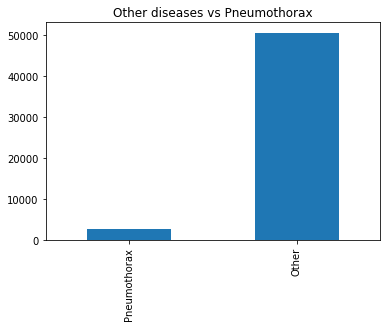

In [198]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [199]:
df_sorted

,Finding Labels,Image Index
Pneumothorax,2637,2637
Other,50500,50500


In [200]:
disease_count = df_sorted['Image Index'][0]
other_disease_count = df_sorted['Image Index'][1]
ratio = (other_disease_count// disease_count)-1
df = df.append([df[df.searching_disease]]*ratio, ignore_index=True) #df.searching_disease: array m true, false 
ratio

18

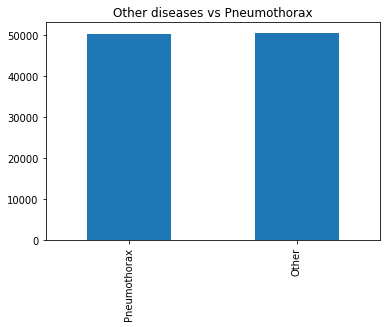

In [201]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [202]:
df = df.drop(['Finding Labels'], axis=1)

In [203]:
df.head()

,Image Index,searching_disease
0,00000002_000.png,False
1,00000005_000.png,False
2,00000005_001.png,False
3,00000005_002.png,False
4,00000005_003.png,False


In [204]:
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv'
df.to_csv(cleaned_label_path, index=False)

In [209]:
with open(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv','w') as f:
    w = csv.writer(f)
    w.writerows(test_dic.items())

# View data 
The validation set we create with the training set may contain images of the same patient as there are several images of a patient. This may lead to better results on the validation set than on test set. 
Since we want a well trained network on chestX-ray 14 data set to look into the value of transfer learning, we have decided to use the test set as the validation set. 

The indexes of all the images that should be in the validation set

In [309]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())
    return ImageClassifierData.from_csv(PATH, 'train', cleaned_label_path, test_name="test" , tfms=tfms, bs=bs);

In [310]:
data = get_data(sz)

In [312]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape, len(data.test_ds.fnames)

((80483,), (20120,), 2)

In [315]:
data.classes[:2]

['False', 'True']

# Training

In [23]:
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, ps=0.5)

In [24]:
learn.lr_find()

 63%|██████▎   | 3694/5818 [03:30<02:00, 17.59it/s, loss=2.25] 

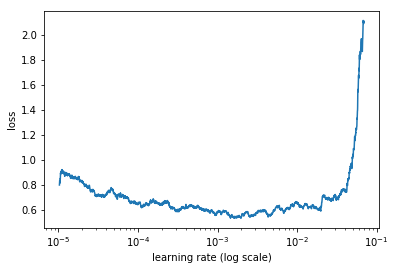

In [39]:
learn.sched.plot()

In [25]:
lr = 0.0001

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  2%|▏         | 136/5818 [00:07<04:58, 19.02it/s, loss=0.862]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.582221   0.522588   0.749805  
    1      0.540364   0.516393   0.749414                      
    2      0.506555   0.512788   0.756329                      
    3      0.514811   0.506562   0.763088                      
    4      0.494153   0.504311   0.758986                      
    5      0.511344   0.503911   0.761369                      
    6      0.495406   0.503093   0.763713                      



[array([0.50309]), 0.7637130801687764]

 62%|██████▏   | 3588/5818 [03:03<01:54, 19.52it/s, loss=1.85] 

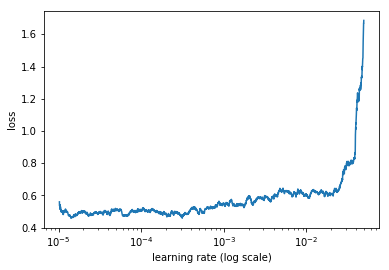

In [27]:
learn.lr_find()
learn.sched.plot()

In [28]:
learn.unfreeze()

In [29]:
lrs = [lr/9, lr/3,lr];

In [30]:
learn.fit(lrs, 1, cycle_len=1)

  1%|          | 67/5818 [00:05<07:53, 12.16it/s, loss=0.708]

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.418737   0.466495   0.790905  



[array([0.46649]), 0.7909048288888271]

In [31]:
learn.save(f'{sz}169{disease_name}') 

In [32]:
sz=128
learn.set_data(get_data(sz))
learn.freeze() 

In [33]:
#learn.lr_find()
#learn.sched.plot()

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.502495   0.503775   0.767972  
    1      0.494192   0.484451   0.776332                      
    2      0.497697   0.482872   0.774809                      
    3      0.473666   0.476808   0.784459                      
    4      0.453199   0.470618   0.788287                      
    5      0.452609   0.467633   0.793561                      
    6      0.462847   0.467116   0.79067                       



[array([0.46712]), 0.7906704172620104]

In [35]:
learn.unfreeze()

In [37]:
learn.fit(lrs, 1, cycle_len=1)  #sette epoch verdi ned til 2 kanskje 

  1%|          | 38/5818 [00:05<13:46,  6.99it/s, loss=0.472]

Exception in thread Thread-23:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.316816   0.439546   0.832904  



[array([0.43955]), 0.8329035786841694]

In [ ]:
learn.save(f'{sz}169{disease_name}')

In [ ]:
#sz = 128
#learn.load(f'{sz}169{disease_name}')

In [38]:
sz = 259

In [39]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
#overfitter veldig når jeg kjører unfreeze

epoch      trn_loss   val_loss   accuracy                      
    0      0.432203   0.457936   0.799969  
    1      0.456715   0.443471   0.807665                      
    2      0.406981   0.441414   0.810322                      
    3      0.425005   0.435954   0.814737                      
    4      0.416947   0.435152   0.813526                      
    5      0.406838   0.435309   0.815792                      
    6      0.407566   0.430547   0.817589                      



[array([0.43055]), 0.8175886857321456]

In [40]:
learn.unfreeze()

In [41]:
learn.fit(lrs, 1, cycle_len=1)

  0%|          | 4/5818 [00:01<35:08,  2.76it/s, loss=0.39]   


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.save(f'{sz}169{disease_name}')

In [ ]:
learn.sched.plot_loss()

#  Analyzing the results

In [ ]:
df_test = pd.read_csv(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv', header=None)

In [ ]:
df_test.columns = ['Image Index', 'searching_disease']
df_test.head()

In [ ]:
data.test_ds.y #denne og den nede skal ligne, men ikke samme størrelse

In [ ]:
pos = 0
remove_index_list = []
fnames = []
y = []
for i in data.test_ds.fnames: 
    img_name = i.replace("test/", "")
    img_row = df_test.loc[df_test['Image Index'] == img_name]
    
    if not img_row.empty: 
        fnames.append(i)
        y.append([float(img_row.searching_disease.values)])
        
    pos +=1

In [ ]:
data.test_ds.fnames = fnames

In [ ]:
data.test_ds.y = np.array(y)

In [ ]:
data.test_ds.y

In [ ]:
#flere kontroll sjekk, type at størrelsen stemmer

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy = accuracy_np(probs, y)

In [ ]:
print('Accuracy with TTA: '+str(accuracy))

In [ ]:
probs

In [ ]:
preds = np.argmax(probs, axis=1)  #selects the position of the highest value
#probs = probs[:,1] 

In [ ]:
cm = confusion_matrix(y,preds);

In [ ]:
plot_confusion_matrix(cm, ['Others', disease_name])

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y, preds)  

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[val_idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, val_idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(val_idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in val_idxs]
    title_probs = [probs[x] for x in val_idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect effusion")